In [1]:
import numpy as np
import scipy as sp
import torch
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas
import nibabel as nib
import sys
sys.path.insert(0,'../deepfly/')
import ft_parser as ft
from scipy.interpolate import interp1d
import sklearn
from sklearn.linear_model import LinearRegression
import torch
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim

2021-11-05 20:16:57.068128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-05 20:16:57.068145: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load in the supervoxel and behavioral data 

In [2]:
# Supervoxel data.
supervoxel_datapath = '/data/minseung/deepfly/supervoxel/non-interpolated/X_all_neural_z_vox_t_correct.npy'
supervoxel_data = np.load(supervoxel_datapath)

# Acquisition timestamps for neural data.
timestamps_path = '/data/minseung/deepfly/supervoxel/non-interpolated/X_all_neural_timestamps_z_t.npy'
X_all_neural_timestamps_z_t = np.load(timestamps_path)

# Forward velocity.
fwd_path = '/data/minseung/deepfly/behavior/20210525_all_beh.npy'
fwd = np.load(fwd_path)

# Clip any negative velocities to 0 and scale the output by 100x.
fwd = np.clip(fwd,0,None) * 100

# Rotational velocity.
rot_path = '/data/minseung/deepfly/behavior/20210525_all_beh_rot.npy'
rot = np.load(rot_path)

# Behaviorial timestamps.
behavioral_timestamps_path = '/data/minseung/deepfly/behavior/20210525_all_beh_time.npy'
behavioral_timestamps = np.load(behavioral_timestamps_path)

## Resample the behavioral data to match the neural and behavioral sampling and write data to disk.

In [ ]:
# Some constants
Z_AXIS_IND = 23 # a z-axis to use
TRAIN_FRAC = .90

# Grab the first and last time points from neural data.
first_tp = X_all_neural_timestamps_z_t[0,0] #from the top z layer
last_tp = X_all_neural_timestamps_z_t[-1,0] #from the top z layer

# Generate the same number of points to match neural data.
timepoints_to_pull = np.linspace(first_tp, last_tp, X_all_neural_timestamps_z_t.shape[0])

# Interpolate neural data to be time-aligned to the top z layer
supervoxel_interp = np.asarray([[np.interp(timepoints_to_pull, X_all_neural_timestamps_z_t[:,z], supervoxel_data[z,sv,:]) for sv in range(supervoxel_data.shape[1])] for z in range(int(supervoxel_data.shape[0]/2))])

# Reshape the data using only one of the Z axes.
n_z_slices,n_supervoxels,t = supervoxel_interp.shape
supervoxel_interp = supervoxel_interp[Z_AXIS_IND,...].reshape(1,n_supervoxels,t)

# Reshape the neural data so that all supervoxels are features.
supervoxel_interp = np.transpose(np.reshape(supervoxel_interp,(supervoxel_interp.shape[0] * supervoxel_interp.shape[1],supervoxel_interp.shape[2])))
  
# Downsample forward velocity.
behavior_interp_obj = interp1d(behavioral_timestamps, fwd, bounds_error = False)
Y = behavior_interp_obj(timepoints_to_pull)
Y = np.nan_to_num(Y)
Y_fwd = Y[:,np.newaxis]

# Now, downsample rotational velocity and stack them together in a matrix.
behavior_interp_obj = interp1d(behavioral_timestamps, rot, bounds_error = False)
Y = behavior_interp_obj(timepoints_to_pull)
Y = np.nan_to_num(Y)
Y_rot = Y[:,np.newaxis]
Y = np.c_[Y_fwd,Y_rot]

# Make a training and testing split and write this to disk.
np.random.seed(2021)
n = supervoxel_interp.shape[0]
inds_all = np.arange(0,n)
train_inds = np.sort(np.random.choice(inds_all,int(np.floor(TRAIN_FRAC * n))))
test_inds = np.setdiff1d(inds_all,train_inds)

# Store the data into a dictionary and write to disk.
train_data = dict()
train_data['supervoxel_interp'] = supervoxel_interp[train_inds,:]
train_data['Y'] = Y[train_inds,:]

outdir = '/data/minseung/deepfly/preprocessed/'

if not os.path.isdir(outdir):
    os.makedirs(outdir)
    
fnameout = os.path.join(outdir,"train_data_layer%s"%str(Z_AXIS_IND))
np.save(fnameout,train_data,allow_pickle=True)

# Same with the testing split.
test_data = dict()
test_data['supervoxel_interp'] = supervoxel_interp[test_inds,:]
test_data['Y'] = Y[test_inds,:]

outdir = '/data/minseung/deepfly/preprocessed/'

if not os.path.isdir(outdir):
    os.makedirs(outdir)
    
fnameout = os.path.join(outdir,"test_data_layer%s"%str(Z_AXIS_IND))
np.save(fnameout,test_data,allow_pickle=True)

## Dataset loader class for torch

In [21]:
class Dataset():
    def __init__(self, data_split):
     
        #df = pd.read_csv(data_split)
        data = np.load(data_split,allow_pickle=True).item()
        self.supervoxel_interp = data['supervoxel_interp']
        self.Y = data['Y']

    def __getitem__(self, index):
        supervoxel = self.supervoxel_interp[index,:]
        y = self.Y[index,:]
        
        return supervoxel, y
          
    def __len__(self):
        return len(self.supervoxel_interp)

## Data set io and data loader initializer

In [5]:
# Constants for now but will be a tested hyperparameter ...
ALPHA = 0.01

# Get the data and initialize the dataloader
train_dataset = Dataset('/data/minseung/deepfly/preprocessed/train_data_layer23.npy')
test_dataset = Dataset('/data/minseung/deepfly/preprocessed/test_data_layer23.npy')
BATCH_SIZE = train_dataset.supervoxel_interp.shape[0]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False)

## Plot some example supervoxels

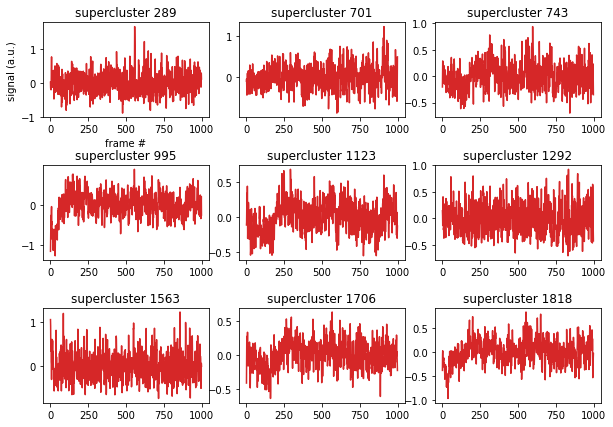

In [50]:
tmp = np.sum(supervoxel_interp,axis=0)
top_inds = np.sort(np.argsort(tmp)[::-1][0:9])

nrow = 3
ncol = 3
fig,ax = plt.subplots(nrow,ncol,figsize=(10,7))
fig.subplots_adjust(hspace=.5,wspace=.18)
i = 0
j = 0

for n in range(9):
    
    ax[i,j].plot(supervoxel_interp[0:1000,top_inds[n]],c='C3')
    ax[i,j].set_title("supercluster %s"%str(top_inds[n]))
    j += 1
    
    if j == ncol:
        j = 0
        i +=1

ax[0,0].set_xlabel('frame #')
ax[0,0].set_ylabel('signal (a.u.)')
plt.savefig('./milestone-figs/supercluster_example.pdf')

## Define the linear model and the loss function


In [12]:
# Simple linear model.
model = nn.Sequential(
          nn.Linear(2000, 2),
        )

# Define the loss function as MSE loss
criterion = nn.MSELoss()

# Define the optimizer with a learning rate
optimizer = optim.Adam(model.parameters(), lr=ALPHA)

In [3]:
# Some constants
Z_AXIS_IND = 23 # a z-axis to use
TRAIN_FRAC = .90

# GVrab the first and last time points from neural data.
first_tp = X_all_neural_timestamps_z_t[0,0] #from the top z layer
last_tp = X_all_neural_timestamps_z_t[-1,0] #from the top z layer

# Generate the same number of points to match neural data.
timepoints_to_pull = np.linspace(first_tp, last_tp, X_all_neural_timestamps_z_t.shape[0])

# Interpolate neural data to be time-aligned to the top z layer
supervoxel_interp = np.asarray([[np.interp(timepoints_to_pull, X_all_neural_timestamps_z_t[:,z], supervoxel_data[z,sv,:]) for sv in range(supervoxel_data.shape[1])] for z in range(int(supervoxel_data.shape[0]/2))])

# Reshape the data using only one of the Z axes.
n_z_slices,n_supervoxels,t = supervoxel_interp.shape
supervoxel_interp = supervoxel_interp[Z_AXIS_IND,...].reshape(1,n_supervoxels,t)

# Reshape the neural data so that all supervoxels are features.
supervoxel_interp = np.transpose(np.reshape(supervoxel_interp,(supervoxel_interp.shape[0] * supervoxel_interp.shape[1],supervoxel_interp.shape[2])))
  
# Downsample forward velocity.
behavior_interp_obj = interp1d(behavioral_timestamps, fwd, bounds_error = False)
Y = behavior_interp_obj(timepoints_to_pull)
Y = np.nan_to_num(Y)
Y_fwd = Y[:,np.newaxis]

# Now, downsample rotational velocity and stack them together in a matrix.
behavior_interp_obj = interp1d(behavioral_timestamps, rot, bounds_error = False)
Y = behavior_interp_obj(timepoints_to_pull)
Y = np.nan_to_num(Y)
Y_rot = Y[:,np.newaxis]
Y = np.c_[Y_fwd,Y_rot]

# Make a training and testing split and write this to disk.
np.random.seed(2021)
n = supervoxel_interp.shape[0]
inds_all = np.arange(0,n)
train_inds = np.sort(np.random.choice(inds_all,int(np.floor(TRAIN_FRAC * n))))
test_inds = np.setdiff1d(inds_all,train_inds)

# Store the data into a dictionary and write to disk.
train_data = dict()
train_data['supervoxel_interp'] = supervoxel_interp[train_inds,:]
train_data['Y'] = Y[train_inds,:]

outdir = '/data/minseung/deepfly/preprocessed/'

if not os.path.isdir(outdir):
    os.makedirs(outdir)
    
fnameout = os.path.join(outdir,"train_data_layer%s"%str(Z_AXIS_IND))
np.save(fnameout,train_data,allow_pickle=True)

# Same with the testing split.
test_data = dict()
test_data['supervoxel_interp'] = supervoxel_interp[test_inds,:]
test_data['Y'] = Y[test_inds,:]

outdir = '/data/minseung/deepfly/preprocessed/'

if not os.path.isdir(outdir):
    os.makedirs(outdir)
    
fnameout = os.path.join(outdir,"test_data_layer%s"%str(Z_AXIS_IND))
np.save(fnameout,test_data,allow_pickle=True)

## Train the model.

In [13]:
# Constant for now but will be a hyperparameter
N_EPOCHS = 100
cost_cache = []

for epoch in range(N_EPOCHS): 
    
      for i, (supervoxel, y) in enumerate(train_loader, 0):
            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propogation
        outputs = model(supervoxel.float())
        
        # calculate the loss
        loss = criterion(outputs, y.float())
        
        # backpropogation + update parameters
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        cost_cache.append(cost)
        if i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))

Epoch:0, Iteration: 0, training cost = 0.6629534959793091
Epoch:1, Iteration: 0, training cost = 0.6309417486190796
Epoch:2, Iteration: 0, training cost = 0.6261227130889893
Epoch:3, Iteration: 0, training cost = 0.5139496326446533
Epoch:4, Iteration: 0, training cost = 0.5239765644073486
Epoch:5, Iteration: 0, training cost = 0.5372633337974548
Epoch:6, Iteration: 0, training cost = 0.49913930892944336
Epoch:7, Iteration: 0, training cost = 0.4805094301700592
Epoch:8, Iteration: 0, training cost = 0.48408353328704834
Epoch:9, Iteration: 0, training cost = 0.4723981022834778
Epoch:10, Iteration: 0, training cost = 0.4511969983577728
Epoch:11, Iteration: 0, training cost = 0.44026535749435425
Epoch:12, Iteration: 0, training cost = 0.43600383400917053
Epoch:13, Iteration: 0, training cost = 0.43018287420272827
Epoch:14, Iteration: 0, training cost = 0.42585083842277527
Epoch:15, Iteration: 0, training cost = 0.42416679859161377
Epoch:16, Iteration: 0, training cost = 0.41914817690849304

## Get the predictions.

In [14]:
# Get the outputs from the test data.
predictions = []

for data in test_loader:
    supervoxel,y = data
    prediction = model(supervoxel.float()).detach().numpy()
    predictions.append(prediction)

predictions = np.vstack(predictions)

## Plot the predicted data.

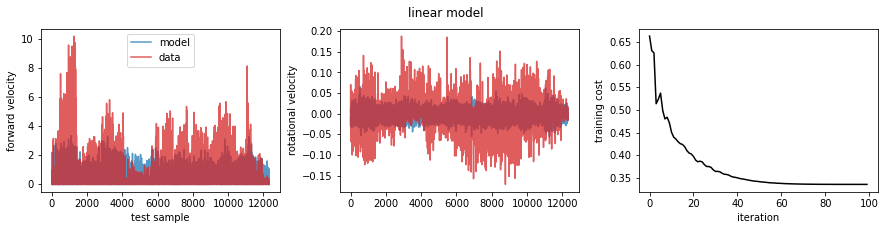

In [15]:
fig,ax = plt.subplots(1,3,figsize=(15,3))
fig.subplots_adjust(wspace=.25)
ax[0].plot(np.maximum(predictions[:,0],0),c='C0',alpha=.75,label='model')
ax[0].plot(test_dataset.Y[:,0],c='C3',alpha=.75,label='data')
ax[0].set_xlabel('test sample')
ax[0].set_ylabel('forward velocity')
ax[0].legend()

ax[1].plot(predictions[:,1],c='C0',alpha=.75)
ax[1].plot(test_dataset.Y[:,1],c='C3',alpha=.75)
ax[1].set_ylabel('rotational velocity')

ax[2].plot(cost_cache,c='k')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('training cost')

plt.suptitle('linear model')
plt.savefig('./milestone-figs/linear_performance.pdf')
plt.show()

## Simple two layer neural network

In [17]:
# Simple 2 layer network.
model = nn.Sequential(
          nn.Linear(2000, 100),
          nn.ReLU(),
          nn.Linear(100,2)
        )

# Define the loss function as MSE loss
criterion = nn.MSELoss()

# Define the optimizer with a learning rate
optimizer = optim.Adam(model.parameters(), lr=ALPHA)

In [18]:
# Constant for now but will be a hyperparameter
N_EPOCHS = 100
cost_cache = []

for epoch in range(N_EPOCHS): 
    
      for i, (supervoxel, y) in enumerate(train_loader, 0):
            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propogation
        outputs = model(supervoxel.float())
        
        # calculate the loss
        loss = criterion(outputs, y.float())
        
        # backpropogation + update parameters
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        cost_cache.append(cost)
        if i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))

Epoch:0, Iteration: 0, training cost = 0.6118825078010559
Epoch:1, Iteration: 0, training cost = 1.153023600578308
Epoch:2, Iteration: 0, training cost = 0.43341609835624695
Epoch:3, Iteration: 0, training cost = 0.5218005180358887
Epoch:4, Iteration: 0, training cost = 0.6045952439308167
Epoch:5, Iteration: 0, training cost = 0.46876445412635803
Epoch:6, Iteration: 0, training cost = 0.3481670916080475
Epoch:7, Iteration: 0, training cost = 0.37734454870224
Epoch:8, Iteration: 0, training cost = 0.4400438964366913
Epoch:9, Iteration: 0, training cost = 0.409542441368103
Epoch:10, Iteration: 0, training cost = 0.34683865308761597
Epoch:11, Iteration: 0, training cost = 0.32163894176483154
Epoch:12, Iteration: 0, training cost = 0.32660919427871704
Epoch:13, Iteration: 0, training cost = 0.338679701089859
Epoch:14, Iteration: 0, training cost = 0.34420618414878845
Epoch:15, Iteration: 0, training cost = 0.33852913975715637
Epoch:16, Iteration: 0, training cost = 0.32356277108192444
Epoc

## Get the predictions

In [19]:
# Get the outputs from the test data.
predictions = []

for data in test_loader:
    supervoxel,y = data
    prediction = model(supervoxel.float()).detach().numpy()
    predictions.append(prediction)

predictions = np.vstack(predictions)

## Plot the predicted data

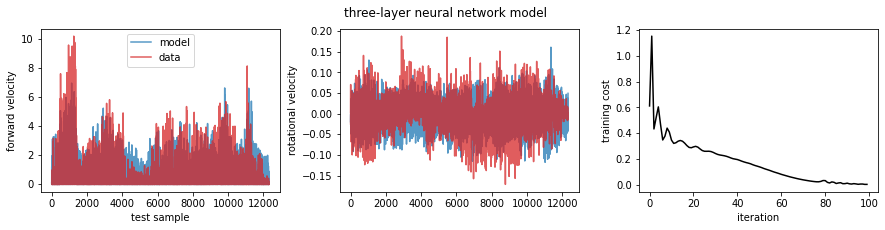

In [20]:
fig,ax = plt.subplots(1,3,figsize=(15,3))
fig.subplots_adjust(wspace=.25)
ax[0].plot(np.maximum(predictions[:,0],0),c='C0',alpha=.75,label='model')
ax[0].plot(test_dataset.Y[:,0],c='C3',alpha=.75,label='data')
ax[0].set_xlabel('test sample')
ax[0].set_ylabel('forward velocity')
ax[0].legend()

ax[1].plot(predictions[:,1],c='C0',alpha=.75)
ax[1].plot(test_dataset.Y[:,1],c='C3',alpha=.75)
ax[1].set_ylabel('rotational velocity')

ax[2].plot(cost_cache,c='k')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('training cost')

plt.suptitle('three-layer neural network model')
plt.savefig('./milestone-figs/three_layer_performance.pdf')
plt.show()